In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# skelearn utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, f1_score, matthews_corrcoef, recall_score, jaccard_score
from sklearn.utils.class_weight import compute_class_weight
# Resample
from imblearn import over_sampling

# ML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 

<h3>Functions</h3>

In [14]:
# Function to verify training history
def plot_history(history: list):
    
    legend = ['Train', 'Validation']
    
    key_list = list(history.history.keys())
    plt.figure(figsize=(6,3*int((len(key_list))/2)))
    for val, metric in enumerate(key_list[0:int((len(key_list))/2)]):
        plt.subplot(int((len(key_list))/2), 1, val+1)
        plt.plot(history.history[metric])
        plt.plot(history.history['val_'+ metric])
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend(legend, loc='best')

In [15]:
def plot_class_distribution(array, name):
    plt.figure(figsize=(5,4))
    ax = sns.histplot(x=array)
    for i in ax.containers:
        ax.bar_label(i,)
    plt.title(f'{name} Data Class Distribution')
    plt.show()

<h3>Loading datasets</h3>

In [16]:
airline_preprocessed = pd.read_csv('Airline-Sentiment_processed.csv')
print(airline_preprocessed.shape)
airline_preprocessed.drop(['text', 'airline'], axis=1, inplace=True)
#airline_preprocessed.drop_duplicates(inplace=True)
airline_preprocessed.dropna(inplace=True)
print(airline_preprocessed.shape)

(14452, 4)
(14445, 2)


In [17]:
airline_preprocessed_sentiment = pd.read_csv('Airline-Sentiment_processed_sentiment.csv')
print(airline_preprocessed_sentiment.shape)
airline_preprocessed_sentiment.drop(['text', 'airline'], axis=1, inplace=True)
#airline_preprocessed_sentiment.drop_duplicates(inplace=True)
airline_preprocessed_sentiment.dropna(inplace=True)
print(airline_preprocessed_sentiment.shape)

(14640, 4)
(14640, 2)


In [18]:
neutral_df = pd.read_csv('neutral_preprocessed.csv')
print(neutral_df.shape)
neutral_df.drop_duplicates(inplace=True)
neutral_df.dropna(inplace=True)
print(neutral_df.shape)

(2988, 2)
(2969, 2)


In [19]:
max_ = 0
for idx in neutral_df.index:
    if len(neutral_df['translated'][idx].split()) == 272:
        max_ = len(neutral_df['translated'][idx].split())
        neutral_df['translated'][idx] = ' '.join(list(set(neutral_df['translated'][idx].split()))) 


In [20]:
positive_df = pd.read_csv('positive_preprocessed.csv')
print(positive_df.shape)
positive_df.drop_duplicates(inplace=True)
positive_df.dropna(inplace=True)
print(positive_df.shape)

(2232, 2)
(2208, 2)


<h2>Prepare the data for the scenarios that we are going see the performance of our models:</h2>
<ul>
    <li>1 - Original Data</li>
    <li>2 - Original Data with "sentiment" (emoticons replaced by word sentiment)</li>
    <li>3 - Original Data with minority classes (positive and negative) augmentation</li>
</ul>

<h3>1 - Split the <u>"original"</u> dataset into test and train</h3>

In [21]:
x_train, x_test, y_train, y_test = train_test_split(airline_preprocessed['text_preprocessed'],
                                                 airline_preprocessed['airline_sentiment'],
                                                 train_size=0.8)

print('Train Shape Features: {} Target: {}'.format(x_train.shape, y_train.shape))
print('Validation/Test Shape Features: {} Target: {}'.format(x_test.shape, y_test.shape))

Train Shape Features: (11556,) Target: (11556,)
Validation/Test Shape Features: (2889,) Target: (2889,)


<h3>2 - Split the <u>"original" with sentiment</u> dataset into test and train</h3>

In [22]:
x_train_S,x_test_S,y_train_S,y_test_S = train_test_split(airline_preprocessed_sentiment['text_preprocessed_sentiment'],
                                                 airline_preprocessed_sentiment['airline_sentiment'],
                                                 train_size=0.8)

print('Train Shape Features: {} Target: {}'.format(x_train_S.shape, y_train_S.shape))
print('Validation/Test Shape Features: {} Target: {}'.format(x_test_S.shape, y_test_S.shape))

Train Shape Features: (11712,) Target: (11712,)
Validation/Test Shape Features: (2928,) Target: (2928,)


<h3>3 - Split <u>original dataset with minority classes augmentation</u></h3>

<p>At this point we have to check in the neutral_df and positive_df, for the original text in the original dataset y_train, and add the translated text to the matching texts to the x_train.</p>

In [23]:
# neutral
tmp = []
for idx in neutral_df.index:
    if neutral_df['original'][idx] in x_train.to_list():
        tmp.append(neutral_df['translated'][idx])
tmp_df = pd.DataFrame(tmp, columns=['text_preprocessed'])
tmp_df['airline_sentiment'] = 'neutral'
tmp_df.shape


(1738, 2)

In [24]:
# positive
tmp_ = []
for idx in positive_df.index:
    if positive_df['original'][idx] in x_train.to_list():
        tmp_.append(positive_df['translated'][idx])
tmp_df_ = pd.DataFrame(tmp_, columns=['text_preprocessed'])
tmp_df_['airline_sentiment'] = 'positive'
tmp_df_.shape

(1491, 2)

<p>Now we create a new dataframe</p>

In [25]:
airline_df_tmp = pd.DataFrame(x_train, columns=['text_preprocessed'])
airline_df_tmp['airline_sentiment'] = y_train

In [26]:
airline_df_aug = pd.concat([airline_df_tmp, tmp_df, tmp_df_], ignore_index=True)
del tmp_df, tmp_df_, airline_df_tmp
print(airline_df_aug.shape)

shuffle(airline_df_aug)

x_train_aug = airline_df_aug['text_preprocessed']
y_train_aug = airline_df_aug['airline_sentiment']

print('Train Shape Features: {} Target: {}'.format(x_train_aug.shape, y_train_aug.shape))
print('Validation/Test Shape Features: {} Target: {}'.format(x_test.shape, y_test.shape))

(14785, 2)
Train Shape Features: (14785,) Target: (14785,)
Validation/Test Shape Features: (2889,) Target: (2889,)


<h3>Model Definition</h3>


In [38]:
def model_definition(vectorize_layer, vocab_size, embedding_dim, dropout_layer=False, ):
    model= Sequential()
    model.add(keras.layers.Input(1, dtype=tf.string))
    model.add(vectorize_layer)
    model.add(keras.layers.Embedding(vocab_size, embedding_dim))
    if dropout_layer:
        model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim, activation='relu')))
    model.add(keras.layers.Dense(embedding_dim, activation='relu'))
    if dropout_layer:
        model.add(keras.layers.Dropout(0,3))
    model.add(keras.layers.Dense(embedding_dim, activation='relu'))
    if dropout_layer:
        model.add(keras.layers.Dropout(0,3))
    model.add(keras.layers.Dense(3, activation='softmax'))

    model.summary()
    
    return model

In [80]:
earlystop = keras.callbacks.EarlyStopping(min_delta=1e-3, patience=5)

def model_training(x_train, x_test, y_train, y_test, name: str, epochs=10):
    
    # checking for the max length of the tweets
    max_ = 0
    for tweets in tqdm(x_train):
        if len(tweets.split()) > max_:
            max_ = len(tweets.split())
    
    vocab_size = 20000
    embedding_dim = 64
    max_length = max_ + 2
    trunc_type = 'post'
    padding_type = 'post'
    oov_tok = '<OOV>'
    
    vectorize = TextVectorization(max_tokens=vocab_size, 
                                  output_mode='int',
                                  output_sequence_length=max_length,                 
                                  )
    vectorize.adapt(x_train)
    print('{} Vocabulary size {}'.format(name, vectorize.vocabulary_size()))
    
    # plot class distribution
    plot_class_distribution(y_train, name)
    
    label_tokenizer = Tokenizer()
    label_tokenizer.fit_on_texts(y_train)
    
    y_train = np.array(label_tokenizer.texts_to_sequences(y_train)) - 1
    y_test = np.array(label_tokenizer.texts_to_sequences(y_test)) - 1
    
   
    
    model = model_definition(vectorize, vocab_size, embedding_dim, dropout_layer=False)
    model.compile(loss='sparse_categorical_crossentropy',
                            optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    num_epochs = epochs
    history = model.fit(x_train,y_train,
                        epochs=num_epochs,
                        validation_data=(x_test, y_test),
                        verbose=1,
                        callbacks=earlystop,
                        batch_size=32,
                        )
    
    prediction_set = model_prediction(model,x_test, y_test, name)
    
    
    return {'model': model, 'history': history, 'prediction': prediction_set}
    

In [77]:
def model_prediction(model, x_test, y_test, name:str):
    y_predict = model.predict(x_test)
    y_predict = np.array(y_predict)
    y_predict_class = []
    for vals in y_predict:
        y_predict_class.append(vals.argmax())
        
    print(classification_report(y_test, y_predict_class))
    f1 = f1_score(y_test,y_predict_class, average='weighted')
    mcc = matthews_corrcoef(y_test,y_predict_class,)
    recall = recall_score(y_test,y_predict_class, average='weighted')
    jcs = jaccard_score(y_test,y_predict_class, average='weighted')
    
    
    
    return {'prediction': y_predict,'f1_score': f1, 'matthews_corr': mcc, 'recall': recall, 'jaccard_score': jcs}

100%|█████████████████████████████████| 11556/11556 [00:00<00:00, 149181.07it/s]


Original Vocabulary size 8935


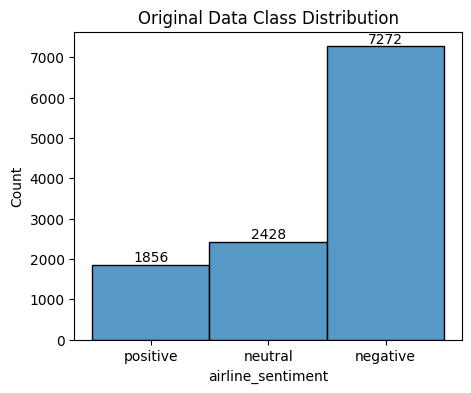

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_15 (Text  (None, 51)               0         
 Vectorization)                                                  
                                                                 
 embedding_11 (Embedding)    (None, 51, 64)            1280000   
                                                                 
 bidirectional_11 (Bidirecti  (None, 128)              66048     
 onal)                                                           
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 64)                4160      
                                                                 
 dense_35 (Dense)            (None, 3)               

In [81]:
original = model_training(x_train,x_test,y_train,y_test, 'Original', epochs= 11)

100%|█████████████████████████████████| 11712/11712 [00:00<00:00, 169092.91it/s]


Sentiment Vocabulary size 10504


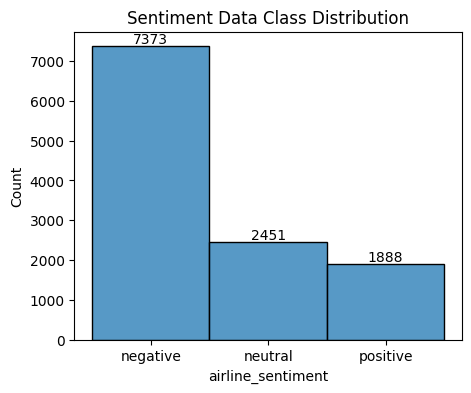

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_16 (Text  (None, 37)               0         
 Vectorization)                                                  
                                                                 
 embedding_12 (Embedding)    (None, 37, 64)            1280000   
                                                                 
 bidirectional_12 (Bidirecti  (None, 128)              66048     
 onal)                                                           
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dense_38 (Dense)            (None, 3)               

In [83]:
original_sentiment = model_training(x_train_S,x_test_S,y_train_S,y_test_S, 'Sentiment', epochs=11)

100%|█████████████████████████████████| 14785/14785 [00:00<00:00, 208722.06it/s]


Original Augmented Vocabulary size 9417


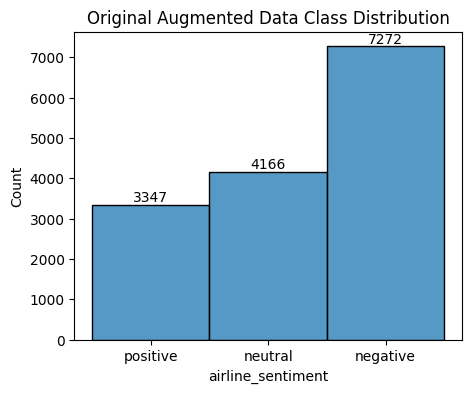

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_17 (Text  (None, 60)               0         
 Vectorization)                                                  
                                                                 
 embedding_13 (Embedding)    (None, 60, 64)            1280000   
                                                                 
 bidirectional_13 (Bidirecti  (None, 128)              66048     
 onal)                                                           
                                                                 
 dense_39 (Dense)            (None, 64)                8256      
                                                                 
 dense_40 (Dense)            (None, 64)                4160      
                                                                 
 dense_41 (Dense)            (None, 3)               

In [84]:
original_aug = model_training(x_train_aug, x_test, y_train_aug, y_test, 'Original Augmented', epochs=11)

In [85]:
original

{'model': <keras.engine.sequential.Sequential at 0x7f75f9d2fdf0>,
 'history': <keras.callbacks.History at 0x7f75874401f0>,
 'prediction': {'prediction': array([[9.9974394e-01, 1.5052196e-04, 1.0560024e-04],
         [9.4805044e-01, 5.1029526e-02, 9.1997802e-04],
         [4.8037931e-01, 1.6611496e-01, 3.5350582e-01],
         ...,
         [9.9999958e-01, 8.1288711e-08, 2.5186597e-07],
         [9.9999851e-01, 6.7413748e-07, 7.1870460e-07],
         [9.9990189e-01, 7.7229663e-05, 2.0887264e-05]], dtype=float32),
  'f1_score': 0.7638739904383247,
  'matthews_corr': 0.5577353383967586,
  'recall': 0.7639321564555209,
  'jaccard_score': 0.6310662011113428}}

In [86]:
original_sentiment

{'model': <keras.engine.sequential.Sequential at 0x7f75877df850>,
 'history': <keras.callbacks.History at 0x7f75832f9ff0>,
 'prediction': {'prediction': array([[9.9946392e-01, 5.3283951e-04, 3.2940388e-06],
         [9.9999958e-01, 3.8019709e-07, 4.2915016e-10],
         [9.4009709e-01, 5.9230242e-02, 6.7271938e-04],
         ...,
         [4.1976357e-01, 5.7821184e-01, 2.0246145e-03],
         [5.2434611e-01, 4.1538933e-01, 6.0264546e-02],
         [9.3019360e-01, 6.4498179e-02, 5.3082476e-03]], dtype=float32),
  'f1_score': 0.7530235122944751,
  'matthews_corr': 0.5449165159476862,
  'recall': 0.757172131147541,
  'jaccard_score': 0.6191040672397071}}

In [87]:
original_aug

{'model': <keras.engine.sequential.Sequential at 0x7f7592f91270>,
 'history': <keras.callbacks.History at 0x7f759299dff0>,
 'prediction': {'prediction': array([[9.9999839e-01, 1.5949201e-06, 5.1632554e-08],
         [9.3241239e-01, 6.6149205e-02, 1.4384105e-03],
         [9.6395618e-01, 2.5146706e-02, 1.0897100e-02],
         ...,
         [9.9933356e-01, 4.9848447e-04, 1.6802919e-04],
         [9.9948853e-01, 5.0905027e-04, 2.3595935e-06],
         [9.9924493e-01, 7.4750424e-04, 7.5824305e-06]], dtype=float32),
  'f1_score': 0.7472332143980832,
  'matthews_corr': 0.5312191561959563,
  'recall': 0.7455867082035307,
  'jaccard_score': 0.609709003537888}}